<h1>Data Visualization and Subdivider Notebook</h1>

<p>This notebook is meant to serve as a continuation of the previous notebook where we downloaded all session data for the Empatica watch</p>

<p>At this point our data consists of folders for each session logged by the patient, divided into folders named for the start data of each session.</p>

<p>The goal of the script this notebook is based upon is threefold:</p>
<ul>
    <li>Visualize the user biometric data from a single session</li>
    <li>Visualize the user biometric data from all sessions</li>
    <li>Create a subset of the data that contains all sessions witin a given date range</li>
</ul>

<p>For the purposes of this notebook we'll only be doing the first and the third points in the above list because plotting every user session, while useful clinically, can be quite difficult in the context of a Python notebook. But note that the logic is essentially the same as for a single patient data session, but iterated over all sessions.</p>

<p>Let's get started by visualizing a single patient data session!</p>

<h3>Single Patient Data Session Visualization</h3>

<p>First things first, let's import all of the Python libraries that we will need for this notebook</p>

In [6]:
import os
import pytz
import time
import json
from datetime import datetime
import shutil
import distutils
from distutils import dir_util
from os import listdir
from os.path import isfile, join
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

<p>Now let's see the data sessions that we have in our current folder for a list of potential analysis folders. We'll do include a little user prompt after seeing our options</p>

In [7]:
!ls

2018-09-18-08:53:02 2018-09-23-08:03:26 2018-09-26-08:46:31 DataSubsetter.ipynb
2018-09-18-11:59:56 2018-09-23-10:46:22 2018-09-26-21:46:01 FunNotebookDataset
2018-09-18-15:21:41 2018-09-23-13:57:51 2018-09-27-03:21:19 Output.png
2018-09-20-08:20:43 2018-09-23-14:11:24 2018-09-27-08:39:38 addHeaders.sh
2018-09-20-14:00:16 2018-09-24-06:34:42 2018-09-27-15:55:33 aggregate_data.py
2018-09-20-16:29:44 2018-09-24-09:10:47 2018-09-27-20:34:55 bvp_analysis.m
2018-09-21-08:22:35 2018-09-24-21:09:04 2018-09-28-06:35:03 data_request.py
2018-09-21-11:21:27 2018-09-25-06:15:13 2018-09-28-18:34:23 mike_script.m
2018-09-22-13:02:10 2018-09-25-19:23:02 2018-09-29-06:32:28 new_analysis.py
2018-09-22-15:48:17 2018-09-25-20:32:11 DataFetcher.ipynb


In [8]:
analysis_session = raw_input('Please provide the folder name for the session that you would like to analyze: ')

Please provide the folder name for the session that you would like to analyze: 2018-09-21-08:22:35


<p>I just chose a random session, but the important thing is that we only chose a single session for this current part of the notebook.</p>

<p>Now that we have a chosen session, we can do some quick analysis.</p>

In [9]:
# We need to get the file names within the session we've chosen.
filenames = [analysis_session + '/' + f for f in listdir(analysis_session + '/') if isfile(join(analysis_session, f))]

# List of files to exclude from our data files list
remove_files = ['/new_analysis.py', '/info.txt', '/json_info.json', '/mike_script.m', '/tags.csv', '/aggregate_data.py', '/bvp_analysis.m']

# Within this session we have to remove a few basic files that are not the .csv files we're interested in.
# This will prevent larger numbers of files than we expect
for i in remove_files:
    if analysis_session+i in filenames:
        filenames.remove(analysis_session + i)
    
for i, filename in enumerate(filenames):
    print i, filename

0 2018-09-21-08:22:35/ACC.csv
1 2018-09-21-08:22:35/BVP.csv
2 2018-09-21-08:22:35/EDA.csv
3 2018-09-21-08:22:35/HR.csv
4 2018-09-21-08:22:35/IBI.csv
5 2018-09-21-08:22:35/TEMP.csv


<p>Great! These are all csv files! So now we have a list of all of the csv files that we'll want to read in and visualize for this session.</p>

<p>Our next step is to split off the endings from the filenames into a separate list for naming and indexing purposes later.</p>

In [10]:
files = [i.strip('.csv') for i in filenames]
files = [i.split('/',1)[1] for i in files]

titles = files

print titles

['ACC', 'BVP', 'EDA', 'HR', 'IBI', 'TEMP']


<p>Now comes the fun part. We need to merge all of the content from each biometric csv file for the patient into one dataframe via Python's Pandas module.<p>

In [11]:
appended_data = []

for i, filename in enumerate(filenames):
    if os.stat(filename).st_size is not 0:
        data = pd.read_csv(
            filename
        )
        appended_data.append(data)
    
df = pd.concat(appended_data, axis=1)

In [12]:
# Brief overview of our dataframe to see if we got everything
df.head()

,Accelerometer x,Accelerometer y,Accelerometer z,BVP,EDA,HR,IBI,TEMP
0.0,32.0,32.0,32.0,64.0,4.000000,1.00,NaN,4.00
1.0,-17.0,-2.0,62.0,-0.0,0.000000,79.00,NaN,34.93
2.0,-17.0,-2.0,62.0,-0.0,0.407365,75.50,NaN,34.93
3.0,-17.0,-2.0,62.0,-0.0,0.479102,74.00,NaN,34.93
4.0,-17.0,-2.0,61.0,-0.0,0.491913,73.25,NaN,34.93


<p>Looking good! We see all of the data that we want, including a separate column for each accelerometer axis.</p>

In [13]:
# Basic statistics on the dataframe
df.describe()

,Accelerometer x,Accelerometer y,Accelerometer z,BVP,EDA,HR,IBI,TEMP
count,326815.000000,326815.000000,326815.000000,653577.000000,40861.000000,10204.000000,210.000000,40705.000000
mean,-31.601919,-11.277203,23.107535,-0.000598,2.751452,108.677126,0.655610,35.286406
std,27.166168,33.831984,26.367627,111.899286,3.365556,28.957734,0.246564,1.023636
min,-128.000000,-128.000000,-128.000000,-2812.130000,0.000000,1.000000,0.312514,4.000000
25%,-54.000000,-35.000000,7.000000,-8.720000,0.320522,87.450000,0.453146,34.930000
50%,-35.000000,-10.000000,26.000000,0.090000,0.549825,103.180000,0.578151,35.680000
75%,-16.000000,-1.000000,44.000000,11.760000,5.029263,126.822500,0.902385,35.890000
max,127.000000,127.000000,127.000000,2310.040000,12.826913,195.980000,1.250057,36.450000


In [14]:
# Information on the actual dataframe object
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 653787 entries, 0.0 to 653576.0
Data columns (total 8 columns):
Accelerometer x    326815 non-null float64
Accelerometer y    326815 non-null float64
Accelerometer z    326815 non-null float64
BVP                653577 non-null float64
EDA                40861 non-null float64
HR                 10204 non-null float64
IBI                210 non-null float64
TEMP               40705 non-null float64
dtypes: float64(8)
memory usage: 44.9 MB


<p>So we see that each metric has a different length. This is due to the different sample rate for each biometric marker based on Empatica's hardware. These sample rates can actually be found in the first row for each signal.</p>

<p>We'll go into a way to normalize these data collection sampling rates later, but for now we're just interested in visualizing our data</p>

<p>One last step before visualization will be a small sample of feature engineering. We want the overall magnitude of the accelerometer data in order to more efficiently remove noise later, so let's add that to our dataframe along with removing the IBI column.</p>

In [15]:
df['acc_mag'] = np.sqrt(np.square(df['Accelerometer x']) + np.square(df['Accelerometer y']) + np.square(df['Accelerometer z'])) 
df.drop('IBI', axis=1, inplace=True)

In [16]:
df.head()

,Accelerometer x,Accelerometer y,Accelerometer z,BVP,EDA,HR,TEMP,acc_mag
0.0,32.0,32.0,32.0,64.0,4.000000,1.00,4.00,55.425626
1.0,-17.0,-2.0,62.0,-0.0,0.000000,79.00,34.93,64.319515
2.0,-17.0,-2.0,62.0,-0.0,0.407365,75.50,34.93,64.319515
3.0,-17.0,-2.0,62.0,-0.0,0.479102,74.00,34.93,64.319515
4.0,-17.0,-2.0,61.0,-0.0,0.491913,73.25,34.93,63.356136


<p>Ok now that we've added our first custom feature to this dataset it's time to start visualizing.</p>

In [17]:
# First we get a list of each sample rate
sample_rates = []
for column in list(df):
    sample_rates.append(int(df[column][0]))

In [18]:
# Function for plotting data
def plot_data(df, titles, sample_rates, iteration, analysis_session, total):
	df = df.reset_index()

	#list(df)[1] = 'Accelerometer' + list(df)[1]
	#list(df)[2] = 'Accelerometer' + list(df)[2]
	#list(df)[3] = 'Accelerometer' + list(df)[3]
	
	plt.figure(iteration, figsize=(10,10))

	for i in range(1,len(list(df)[1:])+1):
		plt.subplot(len(list(df)[1:]),1,i)
		plt.scatter(
			x=df['index'],
			y=df.iloc[:,i],
			s=0.1
		)
		plt.title(list(df)[i])
		plt.xlabel('Sample Number n')
		#plt.ylabel(units[i-1])

	plt.suptitle('Session Occuring at: '+analysis_session)
	plt.subplots_adjust(hspace=2)

	numer = float(iteration+1)
	denom = float(total)

	print 'Plotting Sequence {0:.{1}f}% Complete'.format((numer / denom) * 100, 2)

Plotting Sequence 100.00% Complete


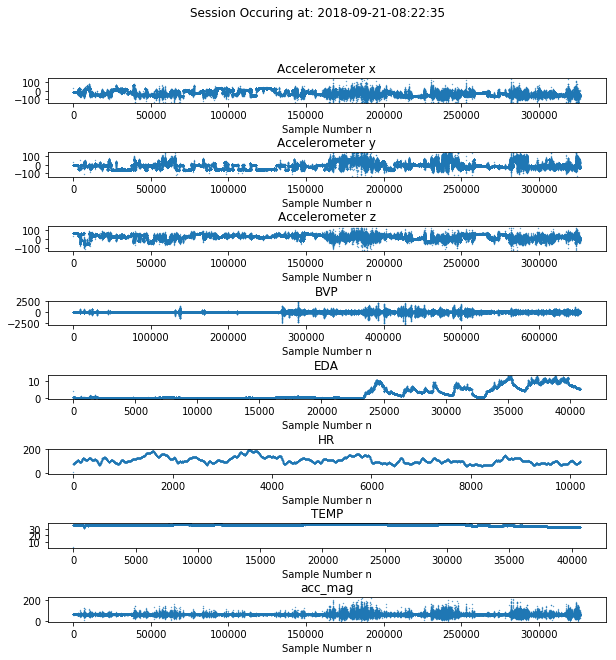

In [19]:
plt = plot_data(df, titles, sample_rates, 0, analysis_session, 1)

<p>Fantastic! We're getting a plot for each biometric marker that we want to see for this patient!</p>

<p>This notebook won't go into further analysis for the signals, as it's just meant to visualize. For now we'll be looking into how to subset the data that we've scraped from Empatica's site for the patient. This will be extremely useful later on when we want experimental controls for different situations or stimuli that a patient is reacting to.</p>

<h3>Subdividing Data for Machine Learning</h3>

<p>Alright, we're going to be taking only a subset of all of our patient session folders and placing them within one overall folder that we can label for clinical use. The first step for doing this is to get a list within Python of all the sessions we have available to us.</p>

In [20]:
dir_names = next(os.walk('.'))[1]
for i, dir in enumerate(dir_names):
    print i, dir

0 .git
1 .ipynb_checkpoints
2 2018-09-18-08:53:02
3 2018-09-18-11:59:56
4 2018-09-18-15:21:41
5 2018-09-20-08:20:43
6 2018-09-20-14:00:16
7 2018-09-20-16:29:44
8 2018-09-21-08:22:35
9 2018-09-21-11:21:27
10 2018-09-22-13:02:10
11 2018-09-22-15:48:17
12 2018-09-23-08:03:26
13 2018-09-23-10:46:22
14 2018-09-23-13:57:51
15 2018-09-23-14:11:24
16 2018-09-24-06:34:42
17 2018-09-24-09:10:47
18 2018-09-24-21:09:04
19 2018-09-25-06:15:13
20 2018-09-25-19:23:02
21 2018-09-25-20:32:11
22 2018-09-26-08:46:31
23 2018-09-26-21:46:01
24 2018-09-27-03:21:19
25 2018-09-27-08:39:38
26 2018-09-27-15:55:33
27 2018-09-27-20:34:55
28 2018-09-28-06:35:03
29 2018-09-28-18:34:23
30 2018-09-29-06:32:28
31 FunNotebookDataset


<p>So we see all of our sessions here. This list will be useful to have printed out so that we can know which dates to choose for our range.</p>

<p>Our next step will be to remove any folders that are listed which are not user data session folders. These are the .git folder and the Python notebook checkpoints folder.</p>

In [27]:
for i, dir_name in enumerate(dir_names):
    if '201' not in dir_name:
        dir_names.remove(dir_name)
        
for i, dir in enumerate(dir_names):
    print i, dir

0 2018-09-18-08:53:02
1 2018-09-18-11:59:56
2 2018-09-18-15:21:41
3 2018-09-20-08:20:43
4 2018-09-20-14:00:16
5 2018-09-20-16:29:44
6 2018-09-21-08:22:35
7 2018-09-21-11:21:27
8 2018-09-22-13:02:10
9 2018-09-22-15:48:17
10 2018-09-23-08:03:26
11 2018-09-23-10:46:22
12 2018-09-23-13:57:51
13 2018-09-23-14:11:24
14 2018-09-24-06:34:42
15 2018-09-24-09:10:47
16 2018-09-24-21:09:04
17 2018-09-25-06:15:13
18 2018-09-25-19:23:02
19 2018-09-25-20:32:11
20 2018-09-26-08:46:31
21 2018-09-26-21:46:01
22 2018-09-27-03:21:19
23 2018-09-27-08:39:38
24 2018-09-27-15:55:33
25 2018-09-27-20:34:55
26 2018-09-28-06:35:03
27 2018-09-28-18:34:23
28 2018-09-29-06:32:28


<p>So now we have a list of all user sessions by date. This is clinically useful as well as useful for our algorithm and model training because we can now choose one or several sessions to subdivide into controls such as "Happy", "Sad", "Exercising", "Stressed", etc.</p>

<p>Let's ask the user for a date range</p>

In [22]:
date_range = raw_input('Enter the range of dates (to the minute and second) between which you would like to retrieve data separated by a space\n\nFormat = 2018-09-20-08:03:06 2018-09-25-08:04:24\n\n=> ')
date_range = date_range.split(' ')

Enter the range of dates (to the minute and second) between which you would like to retrieve data separated by a space

Format = 2018-09-20-08:03:06 2018-09-25-08:04:24

=> 2018-09-24-21:09:04 2018-09-26-21:46:01


<p>We chose a random date range but it's important to note how many data sessions lie in our range. We took the 16th and 22nd sessions so we should have 7 folders in our dataset.</p>

<p>We''ll now convert the two dates we've input into Unix Epoch Time. As mentioned in the previous notebook Unix Epoch Time is the amount of seconds since January 1, 1970 and allows us to perform some easier mathematics on dates which will be important soon.</p>

<p>We will do this conversion twice so let's make a function to convert to Unix Epoch Time.</p>

In [28]:
def format_to_unix(date):

	date_list = date.split('-')
	date_list[3] = date_list[3].split(':')

	unix_time = datetime(int(date_list[0]), int(date_list[1]), int(date_list[2]), int(date_list[3][0]), int(date_list[1])).strftime('%s')

	return unix_time

In [29]:
start_date = format_to_unix(date_range[0])
end_date = format_to_unix(date_range[1])
    
print "Epoch Time Dates: Start {0}, End {1}".format(start_date, end_date)

Epoch Time Dates: Start 1537816140, End 1537988940


<p>We now need to make a list of all sessions that occur within this set date range</p>

In [30]:
filtered_sessions = [dir_name for dir_name in dir_names if format_to_unix(dir_name) >= start_date]
filtered_sessions = [dir_name for dir_name in filtered_sessions if format_to_unix(dir_name) <= end_date] 

<p>Let's make sure that our filtering worked. Remember, we only want data sessions betwen the range that we specified (2018-09-24-21:09:04 2018-09-27-03:21:19)</p>

In [31]:
for i, session in enumerate(filtered_sessions):
    print i, session

0 2018-09-24-21:09:04
1 2018-09-25-06:15:13
2 2018-09-25-19:23:02
3 2018-09-25-20:32:11
4 2018-09-26-08:46:31
5 2018-09-26-21:46:01


<p>Awesome! Now we have the exact names for each session within the range that we specified. Now we need to give a descriptive name for this dataset that we're creating from these sessions.</p>

<p>Here we ask the user for a name and assume they want to make a dataset for this range, but in the original script we give the option to just visualize the data and not create a dataset. For instructive purposes we'll assume that we want a dataset created.</p>

In [33]:
dataset_name = raw_input('What would you like to name your dataset: ')

What would you like to name your dataset: FunNotebookDataset


<p>Now we need to specify the full path within our system that will house all of our data.</p>

In [34]:
dataset_dir = os.path.join(os.getcwd(), dataset_name)
os.makedirs(dataset_dir)

In [35]:
!ls

2018-09-18-08:53:02 2018-09-23-08:03:26 2018-09-26-08:46:31 DataSubsetter.ipynb
2018-09-18-11:59:56 2018-09-23-10:46:22 2018-09-26-21:46:01 FunNotebookDataset
2018-09-18-15:21:41 2018-09-23-13:57:51 2018-09-27-03:21:19 Output.png
2018-09-20-08:20:43 2018-09-23-14:11:24 2018-09-27-08:39:38 addHeaders.sh
2018-09-20-14:00:16 2018-09-24-06:34:42 2018-09-27-15:55:33 aggregate_data.py
2018-09-20-16:29:44 2018-09-24-09:10:47 2018-09-27-20:34:55 bvp_analysis.m
2018-09-21-08:22:35 2018-09-24-21:09:04 2018-09-28-06:35:03 data_request.py
2018-09-21-11:21:27 2018-09-25-06:15:13 2018-09-28-18:34:23 mike_script.m
2018-09-22-13:02:10 2018-09-25-19:23:02 2018-09-29-06:32:28 new_analysis.py
2018-09-22-15:48:17 2018-09-25-20:32:11 DataFetcher.ipynb


<p>We see our folder in the working directory now.</p>

<p>Now we have to copy each session folder within our date range into the folder.</p>

In [37]:
for session in filtered_sessions:
    session_dir = os.path.join(os.getcwd(), session)
    distutils.dir_util.copy_tree(session_dir, dataset_dir+'/'+session)

<p>Now we copy a list of analysis scripts into each of our subsession folder.</p>

In [43]:
shutil.copyfile('new_analysis.py', dataset_dir+'/new_analysis.py')
shutil.copyfile('aggregate_data.py', dataset_dir+'/aggregate_data.py')
shutil.copyfile('mike_script.m', dataset_dir+'/mike_script.m')
shutil.copyfile('bvp_analysis.m', dataset_dir+'/bvp_analysis.m')

In [44]:
!ls

2018-09-18-08:53:02 2018-09-23-08:03:26 2018-09-26-08:46:31 DataSubsetter.ipynb
2018-09-18-11:59:56 2018-09-23-10:46:22 2018-09-26-21:46:01 FunNotebookDataset
2018-09-18-15:21:41 2018-09-23-13:57:51 2018-09-27-03:21:19 Output.png
2018-09-20-08:20:43 2018-09-23-14:11:24 2018-09-27-08:39:38 addHeaders.sh
2018-09-20-14:00:16 2018-09-24-06:34:42 2018-09-27-15:55:33 aggregate_data.py
2018-09-20-16:29:44 2018-09-24-09:10:47 2018-09-27-20:34:55 bvp_analysis.m
2018-09-21-08:22:35 2018-09-24-21:09:04 2018-09-28-06:35:03 data_request.py
2018-09-21-11:21:27 2018-09-25-06:15:13 2018-09-28-18:34:23 mike_script.m
2018-09-22-13:02:10 2018-09-25-19:23:02 2018-09-29-06:32:28 new_analysis.py
2018-09-22-15:48:17 2018-09-25-20:32:11 DataFetcher.ipynb


In [45]:
!ls FunNotebookDataset

2018-09-24-21:09:04 2018-09-25-20:32:11 aggregate_data.py   new_analysis.py
2018-09-25-06:15:13 2018-09-26-08:46:31 bvp_analysis.m
2018-09-25-19:23:02 2018-09-26-21:46:01 mike_script.m


<p>Looks like we've got everything in the session that we want!</p>

<h2>Conclusion</h2>

<p>Woohoo! We now have all of the datasets that we want contained in FunNotebookDatatset as well as all of the analysis scripts there that will help us further analyze our data within that subset!</p>

<p>We've now accomplished all of the important steps for acquiring and subdividing our data and getting it all ready for machine learning or any other signal processing algorithms we would like to apply to it! In further notebooks and Matlab publishing documents we will go into more signal processing theory for individual signals and metrics we are able to obtain from them, but for now we've accomplished everything this notebook set out to do!</p>